In [1]:
# import/load/test model

In [3]:
import requests
from PIL import Image
import torch
import numpy as np
import pandas as pd
from transformers import Swin2SRForImageSuperResolution, Swin2SRImageProcessor

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim

/Users/jkm/Desktop/CS 221/Project/Downsample Images/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import Swin2SRForImageSuperResolution

model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")

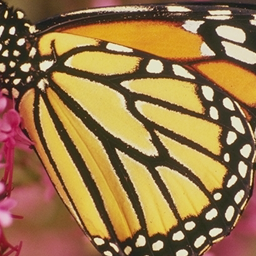

In [5]:
url = "https://huggingface.co/spaces/jjourney1125/swin2sr/resolve/main/samples/butterfly.jpg"

image = Image.open(requests.get(url, stream=True).raw)
image

In [6]:
processor = Swin2SRImageProcessor()
pixel_values = processor(image, do_pad=False, return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 256, 256])


In [7]:
with torch.no_grad():
  outputs = model(pixel_values)
outputs.reconstruction.shape

torch.Size([1, 3, 1024, 1024])

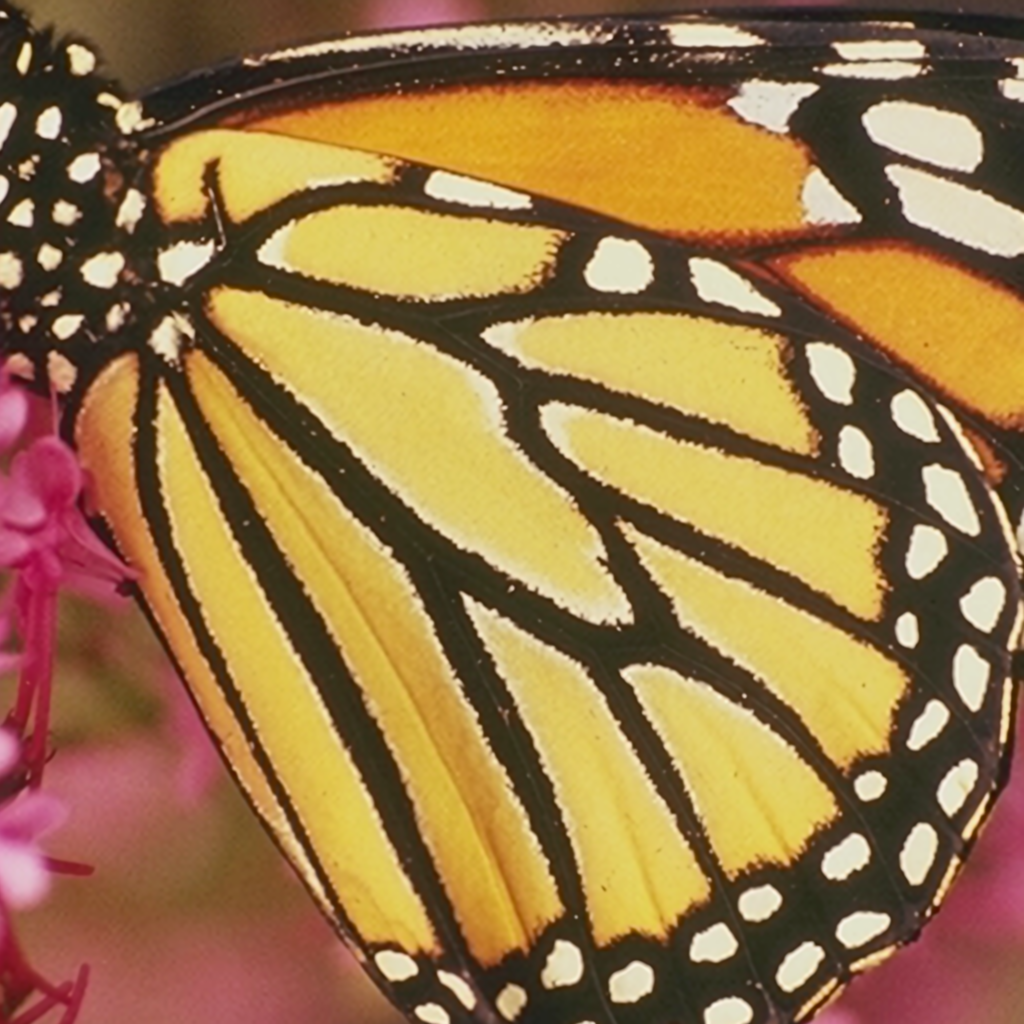

In [8]:
output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
output = np.moveaxis(output, source=0, destination=-1)
output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
Image.fromarray(output)

In [9]:
# Get perf eval on the dataset before fine tuning

In [69]:
model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64") # Note: x4 model not x2
processor = Swin2SRImageProcessor()

def upscale_image(image_path):
    print("Upscaling " + str(image_path))
    image = Image.open(image_path)
    pixel_values = processor(image, do_pad=False, return_tensors="pt").pixel_values

    # print(pixel_values.size())

    with torch.no_grad():
        outputs = model(pixel_values)

    # print(outputs.reconstruction.shape)

    output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy() # normalizes
    output = np.moveaxis(output, source=0, destination=-1) # color channel axes change
    output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
    return Image.fromarray(output)

In [70]:
lr_dir = "00000/LR"
hr_dir = "00000/HR"

# Lists to store results
filenames, psnr_values, ssim_values = [], [], []

# Process each image
for filename in os.listdir(lr_dir):
    lr_image_path = os.path.join(lr_dir, filename)
    hr_image_path = os.path.join(hr_dir, filename)

    # Check if the corresponding HR image exists
    if os.path.exists(hr_image_path):
        # Upscale the LR image
        upscaled_image = upscale_image(lr_image_path)
        # print(f"SR Image Size: {upscaled_image.size}")

        # Load the HR image
        hr_image = Image.open(hr_image_path)
        
        # print(f"HR Image Size: {processed_hr_image.size()}")

        # Convert images to numpy arrays for PSNR and SSIM calculations
        upscaled_image_np = np.array(upscaled_image)
        hr_image_np = np.array(hr_image)

        # Calculate PSNR and SSIM
        psnr = compare_psnr(hr_image_np, upscaled_image_np, data_range=255)
        ssim = compare_ssim(hr_image_np, upscaled_image_np, multichannel=True, channel_axis=-1)

        print(hr_image_path, psnr, ssim)
        
        filenames.append(filename)
        psnr_values.append(psnr)
        ssim_values.append(ssim)

# Create DataFrame
df_results = pd.DataFrame({'Filename': filenames, 'PSNR': psnr_values, 'SSIM': ssim_values})
print(df_results)

Upscaling 00000/LR/00481.png
00000/HR/00481.png 35.590521015545576 0.9059342786132983
Upscaling 00000/LR/00495.png
00000/HR/00495.png 34.52675758480186 0.9008069465894994
Upscaling 00000/LR/00324.png
00000/HR/00324.png 34.6480971910253 0.9147586657447158
Upscaling 00000/LR/00442.png
00000/HR/00442.png 33.82590460076627 0.8764115072334601
Upscaling 00000/LR/00456.png
00000/HR/00456.png 39.43661280206794 0.95732720026368
Upscaling 00000/LR/00330.png
00000/HR/00330.png 31.655068347240768 0.900128779827727
Upscaling 00000/LR/00318.png
00000/HR/00318.png 37.810990428670834 0.9253678390220607
Upscaling 00000/LR/00683.png
00000/HR/00683.png 33.96256194165233 0.881229794180439
Upscaling 00000/LR/00697.png
00000/HR/00697.png 35.422741905350826 0.9082607443313849
Upscaling 00000/LR/00867.png
00000/HR/00867.png 35.26336629732109 0.8634281370783757
Upscaling 00000/LR/00873.png
00000/HR/00873.png 37.23392598903405 0.9228479827143156
Upscaling 00000/LR/00898.png
00000/HR/00898.png 36.806014384726566

In [1]:
df_results.head()

NameError: name 'df_results' is not defined

In [ ]:
# Fine tuning the model

In [ ]:
# Dataset class
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = transform
        self.images = os.listdir(lr_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.images[idx])

        lr_image = Image.open(lr_image_path)
        hr_image = Image.open(hr_image_path)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [ ]:
# Prepare dataset and dataloader
lr_dir = "image_dataset/LR"
hr_dir = "image_dataset/HR"
transform = transforms.Compose([transforms.ToTensor()])

dataset = SuperResolutionDataset(lr_dir, hr_dir, transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
# Load model
fine_tuned_model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x4-64")
model.train()

In [ ]:
# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss()

# Training loop
num_epochs = 10  # Define the number of epochs
save_interval = 2  # Save every 2 epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        lr_images, hr_images = data
        optimizer.zero_grad()

        # Generate SR images
        outputs = model(lr_images)
        sr_images = outputs.reconstruction

        # Compute loss and backpropagate
        loss = criterion(sr_images, hr_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

    # Save the model
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), f"swin2sr_epoch_{epoch+1}.pth")

print("Training complete")